<a href="https://colab.research.google.com/github/LeToyek/2141720085-machine-learning-2023/blob/main/praktikum_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'This is a movie that should be seen by everyone if you want to see great acting. Mr. Torn and Ms Farrel do an outstanding job. I think they should have it on TV again so a new audience can enjoy it. Wonderful performances.<br /><br />It gives you a real feel of what the pioneers had to go through both physically and emotionally. Great unheard of movie.<br /><br />It was done when Ms. Farrel was very young. I had always thought of her as a comedian, but this certainly is not a comedy and she is just wonderful. There is very little dialogs, but that just make it seem more real. Mr. Torn as always is a great presence and just his breathing has great feeling. I must see movie.'
 b'This movie started out with some semblance of a plot, then abandoned it for an endless series of random characters and encounters that have nothing to do with moving the story forward. It was impossible to remain engaged with this film. This movie is a very cynical pile of garbage made by some people w

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,   4, ...,   0,   0,   0],
       [ 11,  18, 628, ...,   0,   0,   0],
       [ 74,  10,  76, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This is a movie that should be seen by everyone if you want to see great acting. Mr. Torn and Ms Farrel do an outstanding job. I think they should have it on TV again so a new audience can enjoy it. Wonderful performances.<br /><br />It gives you a real feel of what the pioneers had to go through both physically and emotionally. Great unheard of movie.<br /><br />It was done when Ms. Farrel was very young. I had always thought of her as a comedian, but this certainly is not a comedy and she is just wonderful. There is very little dialogs, but that just make it seem more real. Mr. Torn as always is a great presence and just his breathing has great feeling. I must see movie.'
Round-trip:  this is a movie that should be seen by everyone if you want to see great acting mr [UNK] and [UNK] [UNK] do an [UNK] job i think they should have it on tv again so a new audience can enjoy it wonderful [UNK] br it gives you a real feel of what the [UNK] had to go through both [UNK] and [UNK

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00362147]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 63ms/step
[-0.00362147]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 101ms/step - loss: 0.6343 - accuracy: 0.5852 - val_loss: 0.4867 - val_accuracy: 0.8000
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3958 - accuracy: 0.8205 - val_loss: 0.3848 - val_accuracy: 0.8401
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3374 - accuracy: 0.8520 - val_loss: 0.3417 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3228 - accuracy: 0.8605 - val_loss: 0.3424 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3154 - accuracy: 0.8620 - val_loss: 0.3290 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3107 - accuracy: 0.8664 - val_loss: 0.3250 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3065 - accuracy: 0.8667 - val_loss: 0.3222 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 15s 39ms/step - loss: 0.3159 - accuracy: 0.8546
Test Loss: 0.31585055589675903
Test Accuracy: 0.8546000123023987


(0.0, 0.6509416699409485)

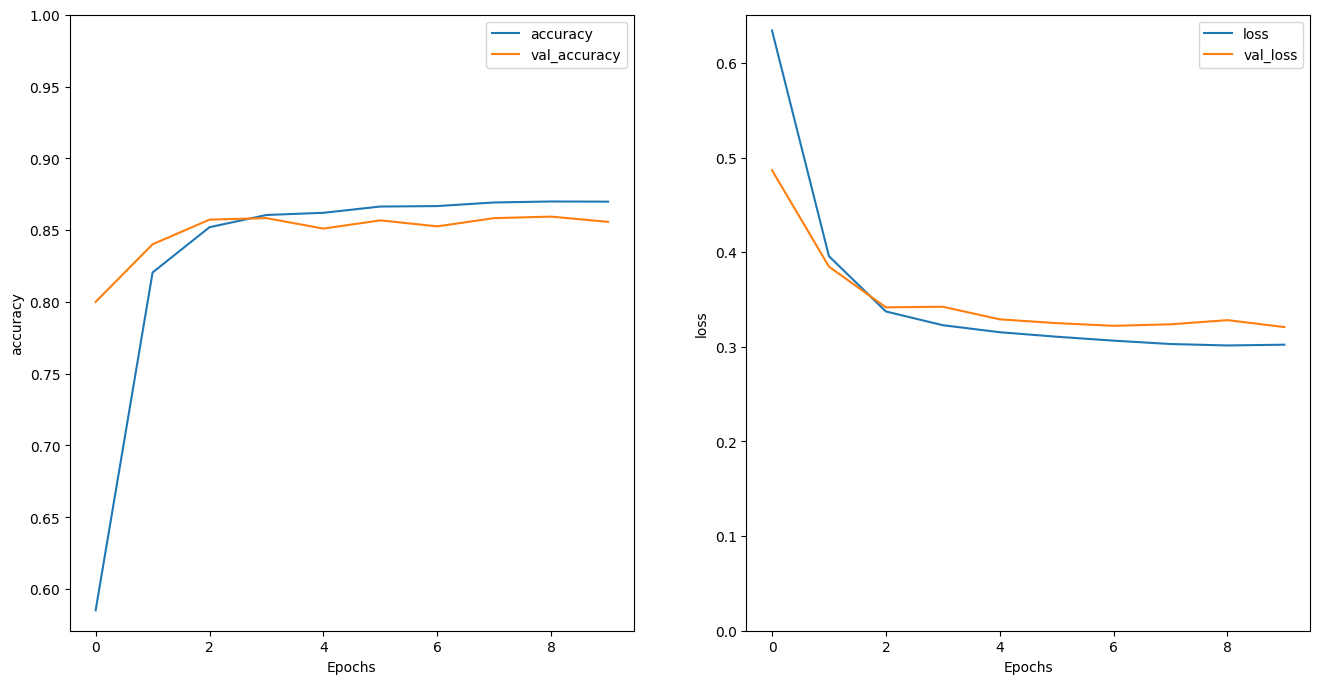

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 82s 162ms/step - loss: 0.6052 - accuracy: 0.6052 - val_loss: 0.4444 - val_accuracy: 0.8271
Epoch 2/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3770 - accuracy: 0.8344 - val_loss: 0.3448 - val_accuracy: 0.8479
Epoch 3/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3341 - accuracy: 0.8548 - val_loss: 0.3265 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3184 - accuracy: 0.8618 - val_loss: 0.3250 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3128 - accuracy: 0.8649 - val_loss: 0.3164 - val_accuracy: 0.8620
Epoch 6/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3020 - accuracy: 0.8708 - val_loss: 0.3214 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3029 - accuracy: 0.8684 - val_loss: 0.3180 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3215 - accuracy: 0.8646
Test Loss: 0.321493923664093
Test Accuracy: 0.8645600080490112


In [27]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.6799723]]


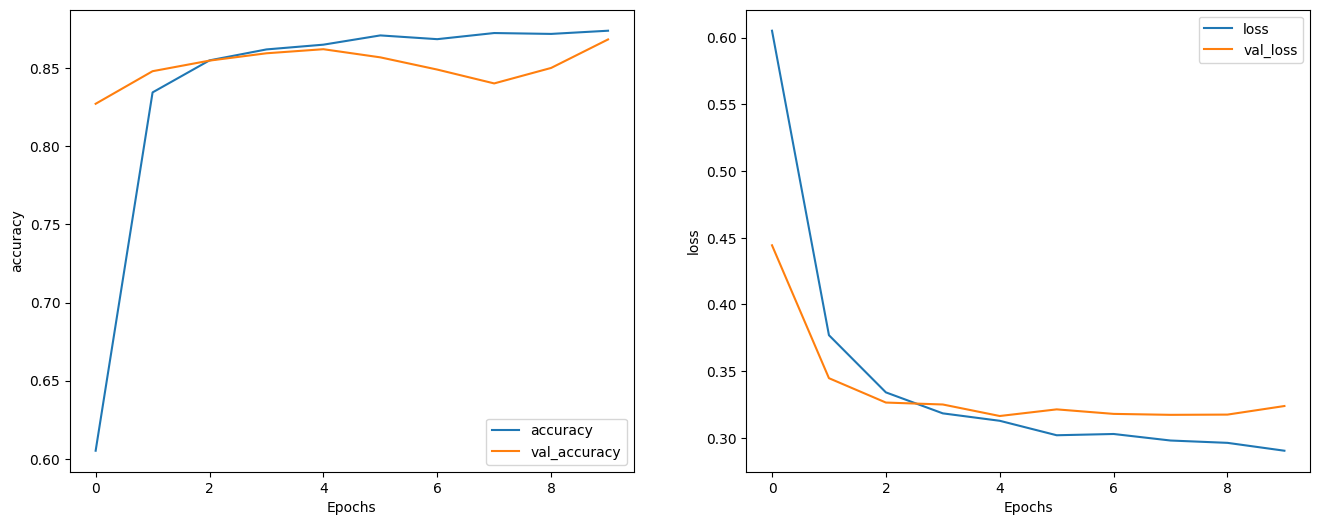

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')